<a href="https://colab.research.google.com/github/engineerJPark/FCN_Implementation/blob/main/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

- validation IoU


- threshold를 놓아보기
- 겹쳐서 보는 거 해보기


In [49]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os


if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

In [50]:
resnet_pretrained = resnet18(weights=ResNet18_Weights.DEFAULT)
# print(resnet_pretrained)

print('Turn Off the inplace operation')
print('.')
print('.')
print('.')

for name, child in resnet_pretrained.named_children():
    if isinstance(child, nn.ReLU):
        resnet_pretrained._modules[name] = nn.ReLU(inplace=False)
    elif isinstance(child, nn.Sequential):
        for sname, schild in child.named_children():
            for ssname, sschild in schild.named_children():
              if isinstance(sschild, nn.ReLU):
                  # print(name,sname,ssname)
                  resnet_pretrained._modules[name]._modules[sname]._modules[ssname] = nn.ReLU(inplace=False)

# print('--------------------------------')
# print('--------------------------------')
# print(resnet_pretrained)

print('Done.')

# torch.autograd.set_detect_anomaly(True)

Turn Off the inplace operation
.
.
.
Done.


In [51]:
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/MyDrive/voc_data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
class VOCClassSegBase(torch.utils.data.Dataset):

    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])

    def __init__(self, root='/content/gdrive/MyDrive/voc_data', split='train', transform_tf=True):
        self.root = root
        self.split = split
        self.transform_tf = transform_tf
        self.transform = transforms.Compose([
            transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
            transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        self.transform_lbl = transforms.Compose([
            transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST)
        ])

        dataset_dir = os.path.join(self.root, 'VOCdevkit/VOC2012')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = os.path.join(
                dataset_dir, 'ImageSets/Segmentation/%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = os.path.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                lbl_file = os.path.join(
                    dataset_dir, 'SegmentationClass/%s.png' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # data file
        data_file = self.files[self.split][index]
        
        # load
        img_file = data_file['img']
        img = PIL.Image.open(img_file)
        img = torch.from_numpy(np.array(img)).to(torch.float)

        lbl_file = data_file['lbl']
        lbl = PIL.Image.open(lbl_file)
        lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
        lbl = torch.unsqueeze(lbl, dim=0)

        # image preprocessing
        img = img.permute(2, 0, 1) # HWC -> CHW
        lbl[lbl == 255] = -1

        # image transform
        if self.transform_tf == True:
            return self.transform(img), self.transform_lbl(lbl)
        else:
            return img, lbl


train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)

train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

In [53]:
# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone()

In [54]:
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7) # error log occured
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

In [55]:
epochs = 10
lr = 10e-4
weight_decay = 2e-4
momentum = 0.9
batch_size = 64

model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [56]:
# train code
def train(model, epochs, optimizer, criterion):
  # with torch.autograd.detect_anomaly():
  for epoch in range(epochs):
    running_loss = 0
    for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
      
      train_img = train_img.to(device)
      train_gt_img = train_gt_img.squeeze(dim=1).to(device)

      score_img = model(train_img)
      score_img = score_img.permute(0,2,3,1).reshape(-1, score_img.shape[1])
      train_gt_img = train_gt_img.reshape(-1, )

      loss = criterion(score_img, train_gt_img)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

      running_loss += loss
    
    print('======================================')
    print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

    EPOCH = epoch
    PATH = "/content/gdrive/MyDrive/fcn_model/model_%d" % (epoch + 1)
    LOSS = running_loss

    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, PATH)
  
  print("Training End")

train(model, epochs, optimizer, criterion)

In [57]:
test_model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/fcn_model/model_%d' % (epochs)

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

test_model.eval()
print('model evaluation start')

model evaluation start


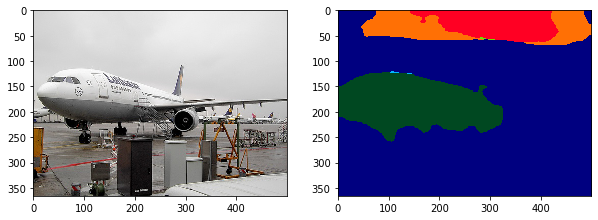

In [60]:
# segmentation : plot image
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')
test_jpg = lines[0] + '.jpg'
test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg))

plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(test_image)

test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1)
ori_x, ori_y = test_image.shape[1], test_image.shape[2]

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([
    transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
return_transform = transforms.Compose([
    transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
])

test_seg = test_model(
    test_transform(test_image)
    )
test_seg = return_transform(test_seg)

test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0)

# print(test_image_channel_idx[30, 75])

test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255) # 320 320 4 
    )

plt.subplot(1,2,2)
plt.imshow(test_image_PIL)
plt.show()

In [59]:
# validation IoU mAP

